# Projecting Food Insecurity Rates in the US by County
## Feature Selection & Modeling Process
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This notebook contains the feature selection and modeling process to predict food insecurity rates based on a number of features, both from the original datasets, as well as engineered features which were created in [feature_engineering.ipynb](feature_engineering.ipynb).

In [74]:
import pandas as pd
import numpy as np
import geopandas as gpd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import cleaned dataset

In [60]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop([ 'coc_number','Low Threshold Type', 'High Threshold Type',
       'State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,FIPS,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,hh_med_income,percent_hh_poverty,hh_avg_size,num_hh,TOT_POP,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_65+,Percent_non_citizen,Percent_hh_no_vehicle,Percent_hh_SNAP,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Houseless_rate_X_Sheltered_rate,Sheltered_rate_X_Percent_grad_degree,Percent_Black_X_Percent_hh_SNAP,Percent_latinX_X_hh_med_income,Cost Per Meal_X_Percent_Black,Unemployment_rate_X_hh_avg_size,Percent_white_X_Percent_hh_SNAP,Rent_X_Unemployment_rate,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Percent_latinX_X_Percent_hh_SNAP,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Percent_latinX_X_percent_hh_poverty,TOT_POP_X_Percent_latinX,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_latinX_X_num_hh,Rent_X_Percent_Black,Num_grocery_X_num_hh,Houseless_rate_X_Percent_pacific,Percent_white_X_percent_hh_poverty,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Sheltered_rate_X_Percent_working,Percent_Black_X_Percent_no_health,Percent_Black_X_percent_hh_poverty,Percent_pacific_X_Percent_disabled,Cost Per Meal_X_Percent_white,Percent_pacific_X_Percent_65+,Sheltered_rate_X_Percent_no_health,TOT_POP_X_Num_grocery,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Sheltered_rate_X_Percent_pacific,Unemployment_rate_X_Percent_hh_SNAP,Percent_latinX_X_Percent_priv_health,Total_food_retail_X_num_hh,Houseless_rate_X_Percent_grad_degree,Percent_pacific_X_Percent_hh_SNAP,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,log_Percent_priv_health,log_Percent_public_health,log_Percent_no_health,log_Percent_65+,log_Percent_non_citizen,log_Percent_hh_no_vehicle,log_Percent_hh_SNAP,log_percent_hh_poverty,log_hh_avg_size,log_num_hh,log_hh_med_income,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
0,01073,1019.995960,2014,0.001396,0.000961,0.000435,45239.0,14.8,2.48,259397.0,659972.0,0.197,2.93,483.0,2693.0,400.0,312131.0,292505.0,19626.0,6.3,0.473491,0.526509,0.538864,0.430446,0.003074,0.015725,0.000526,0.036515,0.461136,0.472946,3576.0,0.005418,0.143315,0.178574,0.123681,0.079964,0.654025,0.320574,0.123242,0.131878,0.026545,0.360953,0.154077,2.711807,3.394842,0.230046,0.000001,0.000077,0.066322,1651.910477,1.261205,15.624,0.083026,6425.974545,0.034420,0.000094,0.005626,0.167234,0.043090,0.540425,24099.0,3.317005,2.982995,0.000169,0.076866,9471.929571,439.052706,103758800.0,7.338020e-07,7.975184,0.352430,0.000283,1.125018,0.902886,0.066410,0.094021,0.000454,0.053049,6.370594,0.000075,1.578871,0.000069,0.000118,263988800.0,19472.925515,0.281522,0.442864,5.052135e-07,0.970682,0.023882,927603672.0,0.000112,0.000081,6.927554,-6.574399,-6.947657,-7.740715,13.399953,1.075002,6.180017,7.898411,5.991465,1.840550,-0.747622,-0.641487,-0.61

# Model 1: All Features
The first model is a simple linear regression model that trains on data from years 2010-2019, uses *all* engineered features created in feature_engineering.ipynb.

### Train/Test Split
**Note:** The rent column is dropped for all models, because rent price data was only available for major metropolitan areas, and therefore retaining the column would require dropping a large majority of rows in order for the models to run. This decision should not significantly impact the performance of the models, given that the relationship between rent and the FI rates is not very strong, as was determined through the EDA process.

In [35]:
# Limit the year and drop rows containing null values in either of the specified columns.
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])

# drop the Rent column, and all engineers features using the rent column
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)

# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop([ 'FIPS','FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)

In [36]:
df_model.shape

(13305, 130)

### Model 1
The model uses 19330 observations (seen above) and uses Cross Validation with 5 folds. It produces a Train/Test R-Squared value of about 0.65, an average Train/Test RMSE of 0.0258, and a mean cross validation score of 0.586.

In [37]:
# Instantiate Linear Regression model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_1.score(X_train, y_train))
print('R2 Test:',model_1.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

scores =cross_val_score(model_1, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8892989053415311
R2 Test: 0.8866477741238107
RMSE Train: 0.014227407918802375
RMSE Test: 0.014403006844135363 

CV Scores: [0.85298764 0.87968246 0.81489992 0.7503781  0.90243984]
Mean CV Score: 0.840077590566762


# Model 2: Remove Outliers
The EDA notebook included a section on inspecting which features have the largest outliers, using box and whisker plots. The following cell focuses on the features with highest outliers: `'TOT_POP'`, `'num_hh'`, `'Total_workforce'`, `'Employed'`, `'hh_avg_size'`,`'Unemployed'`, `'Unemployment_rate_X_hh_avg_size'`,`'Total_workforce'`, and `'Total_food_retail'`

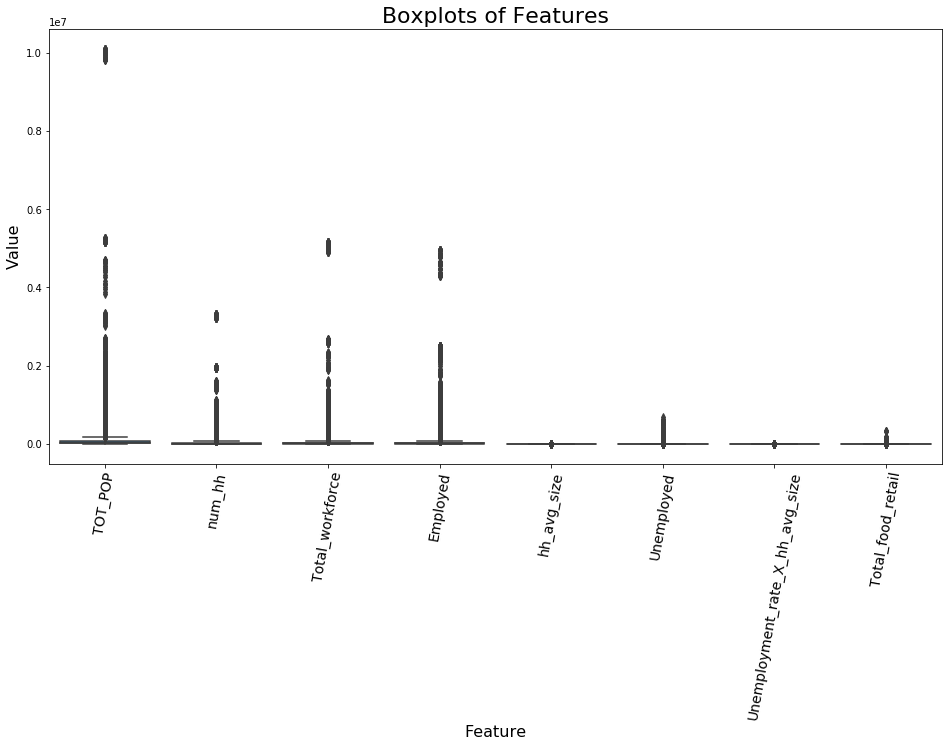

In [38]:
features = ['TOT_POP', 'num_hh', 'Total_workforce', 'Employed', 'hh_avg_size', 'Unemployed',
            'Unemployment_rate_X_hh_avg_size', 'Total_food_retail']

# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.loc[:,features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=80,fontsize=14);


## Remove Outliers
The following cell iterates over each feature with outliers, and if the feature has obsrvations *greater* than +/- 2 standard deviations of the mean, it reduces outliers to +/- 2 standard deviations from the mean of that feature.

In [39]:
# Bring outliers down/up to 2 standard deviations from the mean 
df_out = df.copy()
for feat in features:
    abv_2_std = df_out[feat].mean()+ 2* df_out[feat].std()
    below_2_std = df_out[feat].mean()- 2* df_out[feat].std()
    conditions = [df_out[feat]>abv_2_std, df_out[feat]<below_2_std]
    choices = [abv_2_std, below_2_std]
    df_out[feat] = np.select(conditions, choices, df_out[feat])


### Visualize Again
After reducing outliers, the boxplots are visualized again:

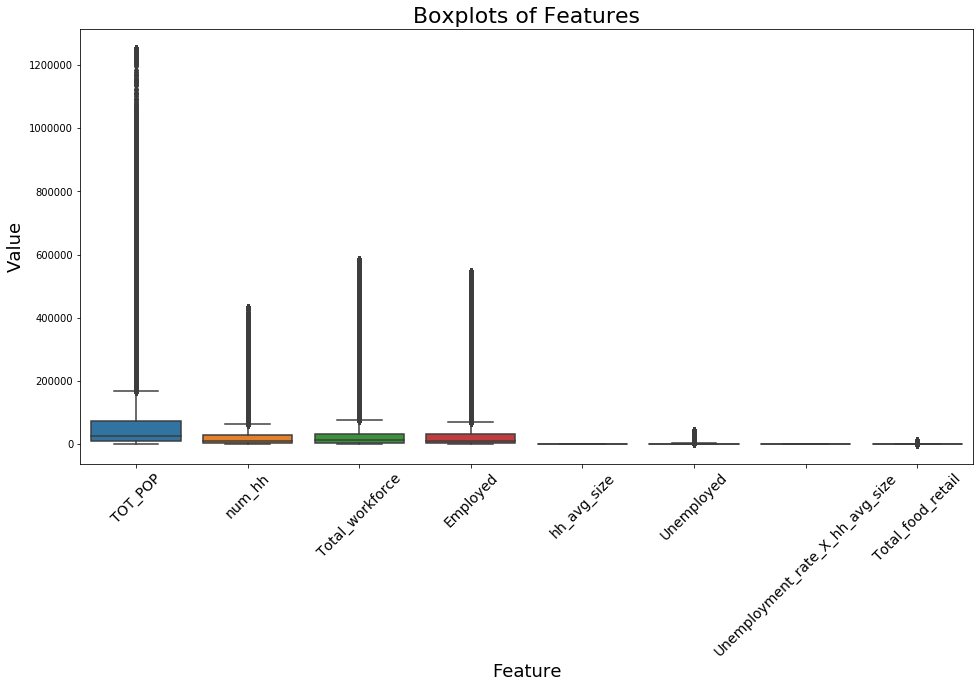

In [8]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df_out[features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':18});
plt.xlabel('Feature', fontdict={'fontsize':18});
plt.xticks(rotation=45,fontsize=14);

## Train/Test Split 2
Perform train/test split similarly as above, after massive outliers have been reduced

In [40]:
# Limit the year and drop null values
df_model = df_out[df_out.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model 2
Re-run the model using the same process as model 1, now on data with reduced outliers.<br>
Model 2 produces a slightly better Train/Test R-Squared value of about 0.76, a worse average Train/Test RMSE of about 0.0214, and a much lower mean cross validation score of 0.503.<br>**For this reason, outliers are retained in the following models.**

In [41]:
# Instantiate Linear Regression model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_2.score(X_train, y_train))
print('R2 Test:',model_2.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_2, X, y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8908827406025875
R2 Test: 0.8897799367272011
RMSE Train: 0.014137231644416826
RMSE Test: 0.0141678804345517
CV Scores: [0.88725007 0.88018339 0.8007533  0.75546926 0.90282636]
Mean CV Score: 0.8452964747933043


# Feature Selection
The following processes use a few different feature selection methods to determine the optimal features for the MVP model
### Train/Test Split 3 
Need to do this again to add outliers back in

In [42]:
# create df_model again, with outliers included this time
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
        
# isolate target variable and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Multicollinearity 
Multicollinearity can create noise within the data. A heatmap is produced from correlation matrix in the [EDA.ipynb](EDA.ipynb) notebook, which highlights that houseless rate, sheltered/unsheltered rates, and all of the race-related features are highly correlated with one another. The following cells explain the correlation between feature pairs even more:
### Inspect correlation between each feature pair
The correlation matrix is reformatted to show the correlation between each feature pair - we see that demographics features, employment-related features, and houselessness-related features are all highly correlated, which is to be expected.

In [12]:
# reformat the correlation matrix and output top 15 pairs
corr=df_model.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.95) & (corr.correlation <1.0)][:15]

,correlation,pairs
7952,0.999764,"(Num_grocery_X_num_hh, TOT_POP_X_Num_grocery)"
9968,0.999764,"(TOT_POP_X_Num_grocery, Num_grocery_X_num_hh)"
1665,0.999674,"(Total_workforce, Employed)"
1791,0.999674,"(Employed, Total_workforce)"
902,0.999181,"(TOT_POP, Total_workforce)"
...,...,...
12337,0.998215,"(log_Percent_male, Percent_female)"
2383,0.998215,"(Percent_female, log_Percent_male)"
2256,0.998215,"(Percent_male, log_Percent_male)"
12336,0.998215,"(log_Percent_male, Percent_male)"


### Varience Inflation Factor
Variance inflation factor (VIF) helps quantifies the severity of multicollinearity in a regression model, by comparing variance of the model with different terms. High VIF scores indicate severe multicollinearity. The following cell creates a dataframe only with features that have VIF scores below 10:

In [14]:
# create a vif dataframe with all features of scores below 10
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <40]['features']
vif[vif['VIF Factor'] <40].head()

,VIF Factor,features
21,36.698875,Percent_asian
27,3.677094,Food_retail_per_person
30,38.828448,Percent_bachelors
36,25.860224,Percent_non_citizen
37,17.032275,Percent_hh_no_vehicle


## Model 3: Removed Multicollinear Features
Model 3 uses only features with VIF scores below 10. It performs significantly worse than the prior models, with a Train/Test R-Squared value of about 0.46, a Train/Test RMSE of about 0.031, and a much lower mean cross validation score of 0.40.


In [142]:
# Instantiate Linear Regression model
model_3 = LinearRegression()
model_3.fit(X_train[vif_features], y_train)
y_train_pred = model_3.predict(X_train[vif_features])
y_test_pred = model_3.predict(X_test[vif_features])

# R2 of training and test set
print('R2 Train:',model_3.score(X_train[vif_features], y_train))
print('R2 Test:',model_3.score(X_test[vif_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_3, X[vif_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.7714817122967168
R2 Test: 0.7698157613746619
RMSE Train: 0.020535586404262608
RMSE Test: 0.02024010385380121
CV Scores: [0.78680354 0.75927551 0.70308813 0.64796717 0.7771292 ]
Mean CV Score: 0.7348527101555817


## Model 4: K-Best Selected Features
Model 4 uses `SelectKBest()` to determine the best k featues to use in a model. The cell below loops through a number of k values to determine the optimal one.

In [44]:
# # determine optimal k with a loop 

for k in range(115,126):
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)
    kbest_features = X_train.columns[selector.get_support()]
    model_3 = LinearRegression()
    model_3.fit(X_train[kbest_features], y_train)
    y_test_pred = model_3.predict(X_test[kbest_features])
    print(k,'\n', model_3.score(X_test[kbest_features],y_test))
    print(np.mean(cross_val_score(model_1, X[kbest_features], y, cv=5,  scoring='r2')))


115 
 0.8893838637303577
0.8484131784353611
116 
 0.8891515888041323
0.8451337022501162
117 
 0.8892109665254302
0.8451822820610729
118 
 0.8895395581046048
0.8460677481479182
119 
 0.88946727244753
0.8453713687737767
120 
 0.8901626054967534
0.8420961368672769
121 
 0.8901436396821766
0.8290859204078445
122 
 0.889860678234869
0.8357217047459988
123 
 0.8890869585882291
0.838365915659586
124 
 0.8901870515161217
0.8392777644427591
125 
 0.8902239210949645
0.8364648247836115


### Model 4
The best k value is determined to be 122, so model 4 is run with those features. Model 4 performs significantly better than others, with an average **R-squared value of .79**, an **RMSE of .0199**, and an average **cross validation score of 0.743.**

In [45]:
# run model with best k features
selector = SelectKBest(f_regression, k=120)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

model_4 = LinearRegression()
model_4.fit(X_train[kbest_features], y_train)
y_train_pred = model_4.predict(X_train[kbest_features])
y_test_pred = model_4.predict(X_test[kbest_features])

# R2 of training and test set
print('R2 Train:',model_4.score(X_train[kbest_features], y_train))
print('R2 Test:',model_4.score(X_test[kbest_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

# cross validation scores
scores =cross_val_score(model_4, X[kbest_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8892890011373857
R2 Test: 0.8901626054967534
RMSE Train: 0.014274775156470954
RMSE Test: 0.01403846298421197
CV Scores: [0.8796017  0.88095325 0.79963982 0.74877025 0.90151567]
Mean CV Score: 0.8420961368672769


## Model 5: Recursive Feature Elimination
Recursive feature elimination is used to iteratively remove features and rerun the model, in order to find an optimal set of features to use.
### Run RFE to retrieve set of rfe_features

In [46]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

### Model 5:
The RFE model performs approximately as well as the Select K Best model, with an average **R-squared value of .79**, an **RMSE of .0198**, and an average **cross validation score of 0.749**.

In [47]:
model_5 = LinearRegression()
model_5.fit(X_train[rfe_features], y_train)
y_train_pred = model_5.predict(X_train[rfe_features])
y_test_pred = model_5.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',model_5.score(X_train[rfe_features], y_train))
print('R2 Test:',model_5.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(model_5, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8900418699041329
R2 Test: 0.8894724664335436
RMSE Train: 0.014226155933238747
RMSE Test: 0.01408249771612748 

CV Scores: [0.88717638 0.87953105 0.815055   0.75182745 0.90412992]
Mean CV Score: 0.8475439590526068


# Evaluation

## Compare predictions to actual values
View FI test predictions alongside the actual FI values - predicitons are visually close to the actual values which is reassuring

In [48]:
test_set = pd.concat([X_test, y_test],axis=1).reset_index()
df_preds = pd.concat([test_set,pd.Series(y_test_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds[['FI Rate','Y Test Preds']].sample(10)

,FI Rate,Y Test Preds
1573,0.2105,0.170356
2672,0.0900,0.085432
1146,0.0820,0.087973
189,0.1790,0.186690
747,0.1800,0.197622
913,0.1150,0.096253
1995,0.1290,0.143972
1869,0.1865,0.188988
1739,0.1730,0.181907
2633,0.1130,0.108083


## Final Model Feature Importance
inspect all the rfe features used in the final model

In [49]:
rfe_features

Index(['Houseless_rate', 'Sheltered_rate', 'Unsheltered_rate', 'hh_med_income',
       'percent_hh_poverty', 'hh_avg_size', 'Cost Per Meal', 'Num_wholesale',
       'Num_restaraunts', 'Num_grocery',
       ...
       'log_Percent_hh_no_vehicle', 'log_Percent_hh_SNAP',
       'log_percent_hh_poverty', 'log_hh_avg_size', 'log_num_hh',
       'log_hh_med_income', 'Lo_thresh_SNAP', 'Lo_thresh_SNAP_other',
       'Hi_thresh_SNAP_other', 'Hi_thresh_other'],
      dtype='object', length=119)

### Model Coefficients
View the ten highest coefficients alongside their corresponding features -- from the output, we see that Houseless rates intersected with race are the highest predictors for food insecurity, which is not suprising after doing EDA on this data.

In [50]:
sorted(list(zip(model_5.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(62037.758589708064, 'Houseless_rate'),
 (218.85856927659063, 'Percent_pacific_X_Percent_65+'),
 (20.19128668947559, 'Percent_white_X_Percent_pacific'),
 (19.71258551471384, 'Percent_Black_X_Percent_no_health'),
 (9.941551655025158, 'Percent_Black_X_hh_med_income'),
 (3.12034880589502, 'Sheltered_rate_X_Percent_working'),
 (1.8965686154887607, 'Percent_white_X_Percent_hh_SNAP'),
 (1.5688322991389612, 'Percent_latinX_X_num_hh'),
 (1.5489801046605862, 'Unemployed'),
 (1.0513599973815246, 'TOT_POP_X_Percent_latinX')]

## Visualize Predicitons on a Map
The following cells make predicitions on all 2018 data, using the best RFE model, and then visualize these predicitons in a choropleth map alongside the actual FI values for 2018.

In [51]:
# Create dataframe for just 2018
df_18 = df[df.Year.isin(['2018'])].dropna(subset=['Num_wholesale','Percent_disabled','Houseless_rate','hh_med_income'])
df_18

for col in df_18.columns:
    if 'Rent' in col:
        df_18.drop(col,axis=1,inplace=True)
        
# separate target and features
y = df_18['FI Rate']
X = df_18.drop(['FIPS', 'FI Rate','Year'],axis=1)

Make predictions and inspect preds vs actual values side-by-side

In [52]:
# Use RFE model to predict on all 2018 data, and create new column in dataframe for predictions
preds_2018 = model_5.predict(X[rfe_features])
        
df_preds = pd.concat([df_18.reset_index() ,pd.Series(preds_2018)],axis=1,).rename(columns={0:'Predicted FI Rate'})
df_preds[['FI Rate','Predicted FI Rate']].sample(10)


,FI Rate,Predicted FI Rate
1411,0.125,0.120628
2433,0.087,0.091370
1871,0.151,0.139269
455,0.185,0.159016
1413,0.131,0.116486
2266,0.150,0.145881
527,0.103,0.107571
826,0.103,0.092646
1966,0.103,0.090265
2708,0.218,0.133059


### Create Choropleth maps of predictions
The maps below indicate that the model was able to capture the general trends of food insecurity, especially in places which are the most significantly impacted. The model did not perform as well at capturing the severity of FI rates in certain areas, such as Maine, the Pacific Northwest, and the Southeast.

White areas are counties which contained missing values, due to a lack of data specific to a feature for the year 2018.

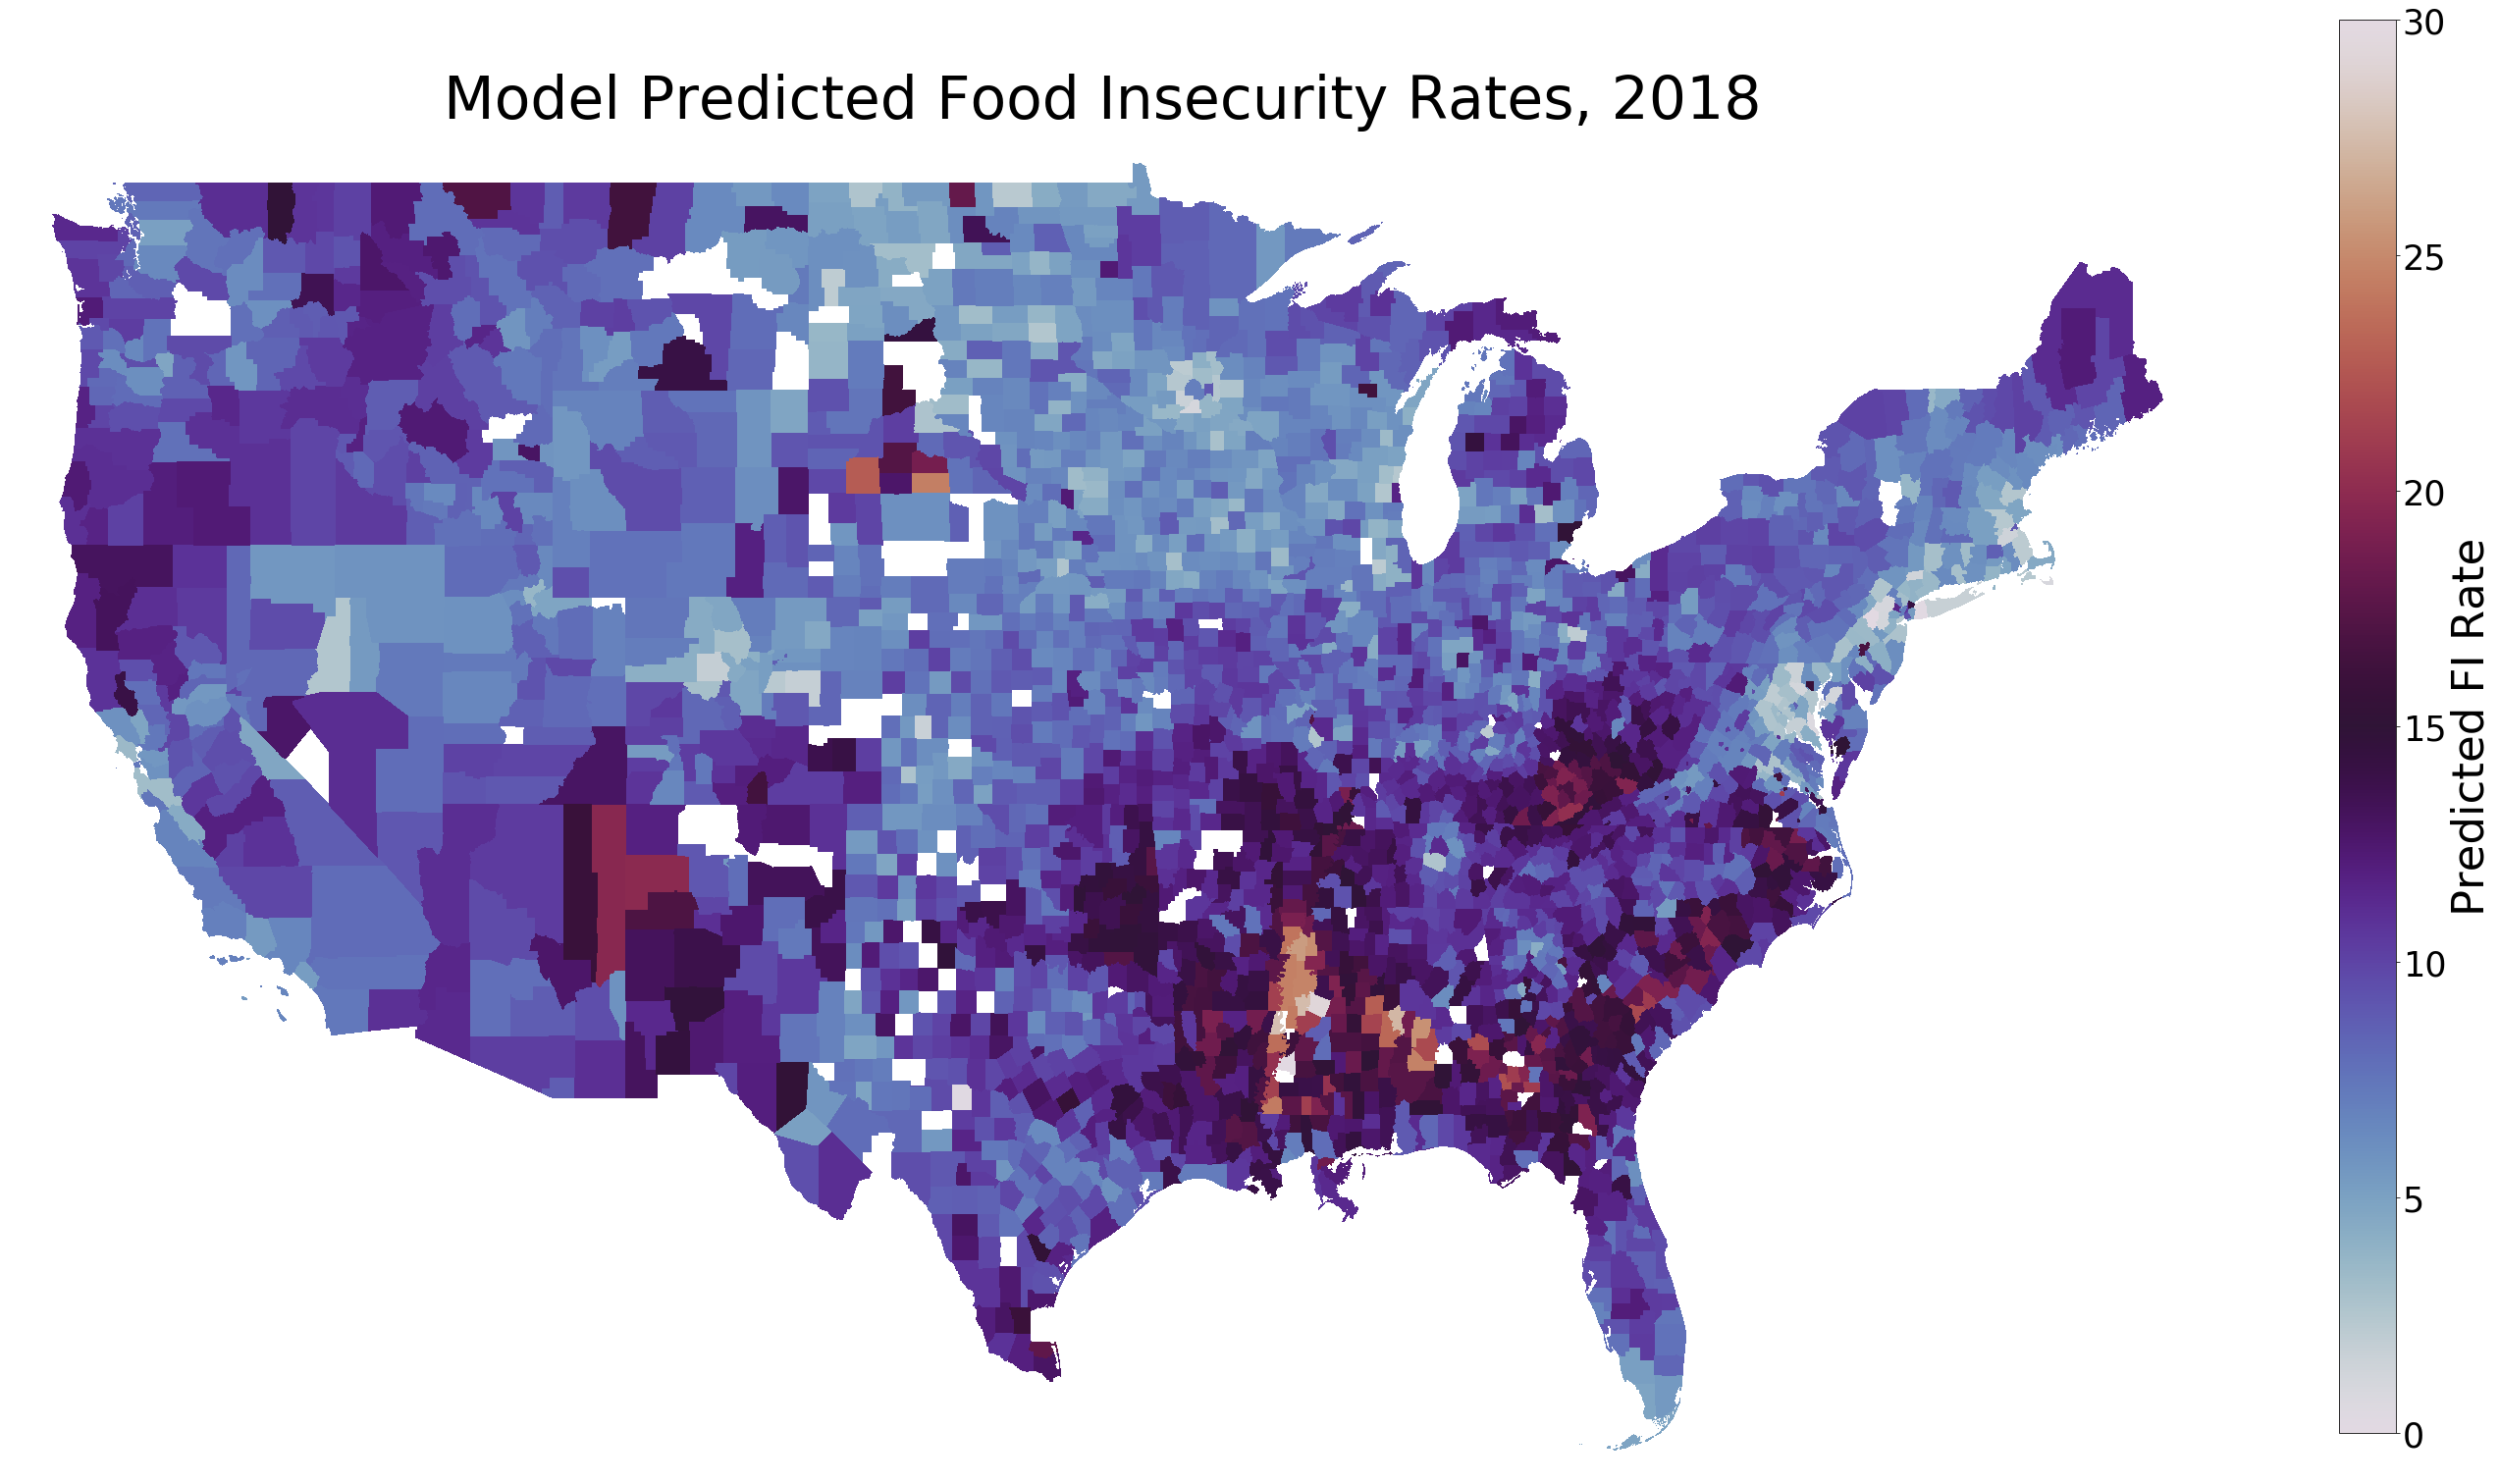

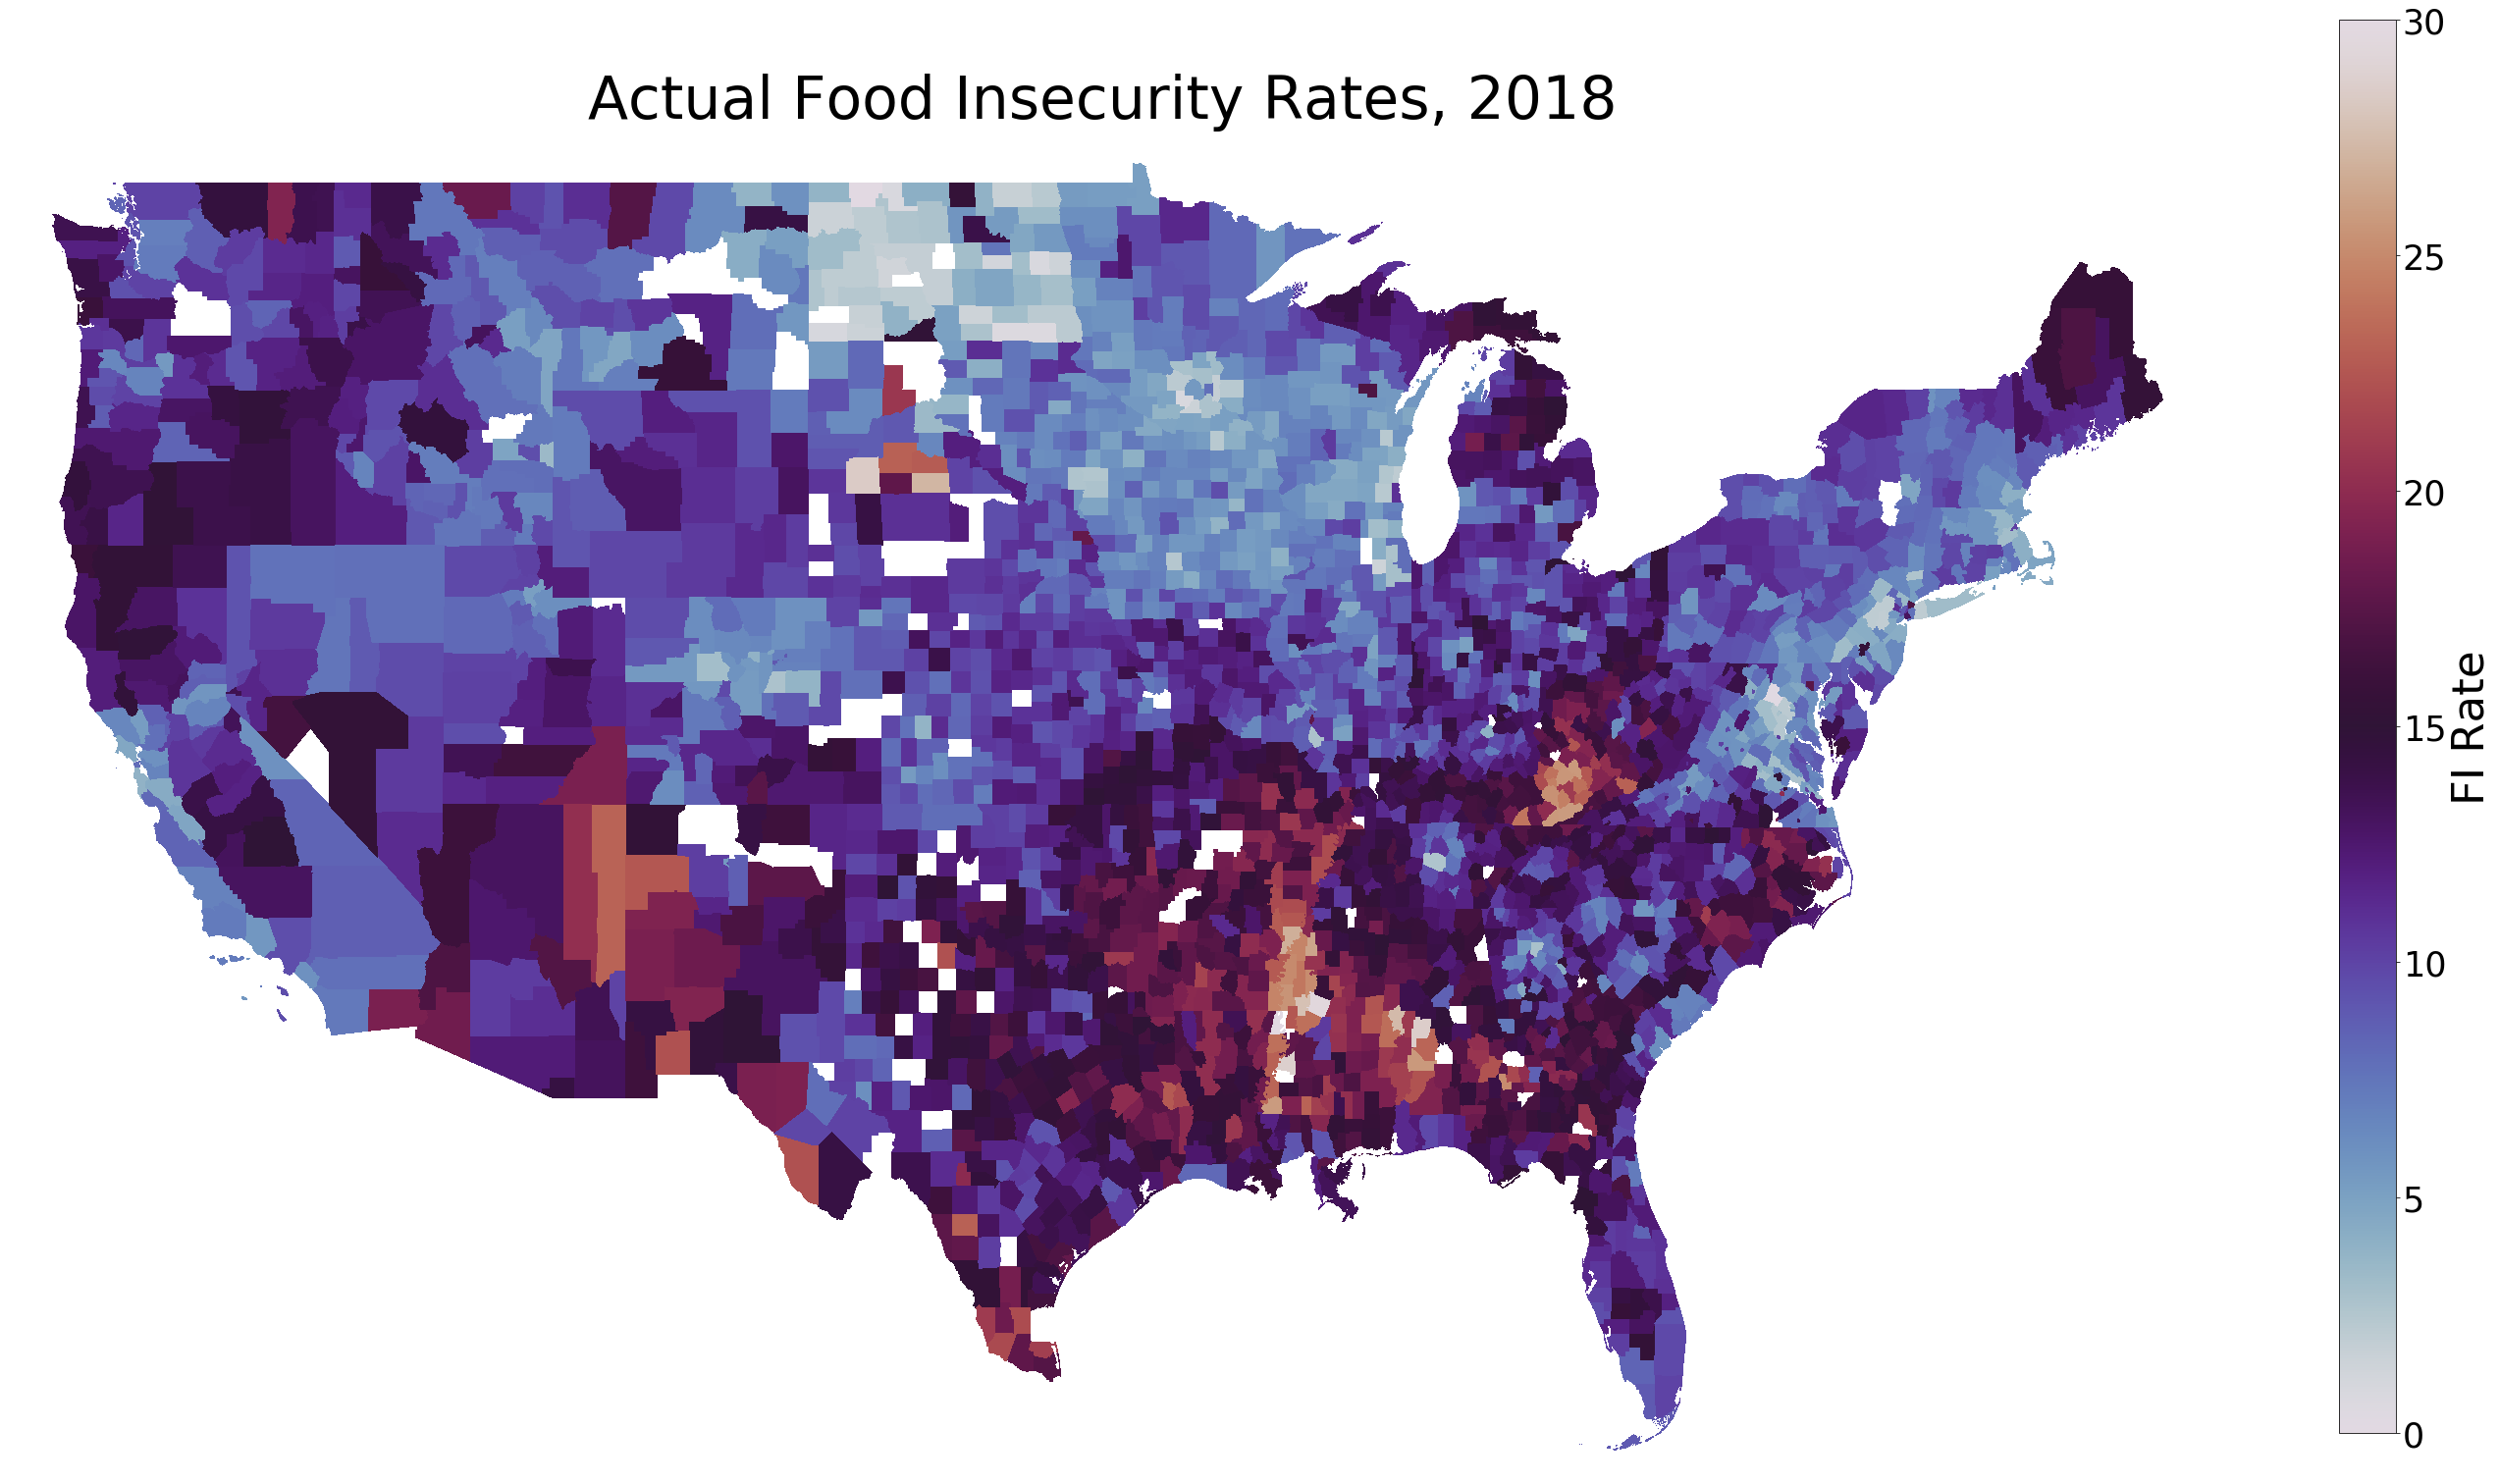

In [22]:
choropleth(df_preds,'Predicted FI Rate','2018','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_preds,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

# Unlabeled 2020 Predictions
Train model on all years, limited to the features that are available for 2020 data -- this excludes Houselessness, Food Retail, Number of Households, Vehicle Access, SNAP Benefits, and more. After model is trained on labeled data, it is used to make predictions for 2020 food insecurity rates. 
### Drop columns that do not exist in 2020 dataset

In [66]:
df_model = df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018', '2019'])]

for col in df_model.columns:
    if 'Rent' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_model.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_model.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_model.drop(col,axis=1,inplace=True)

# Create dataframe for just 2018
df_model.dropna(subset=['Percent_no_health','Total_workforce','hh_med_income', 'FI Rate'],inplace=True)


### Train/Test Split the trimmed data

In [67]:
# separate target and features
y = df_model['FI Rate']
X = df_model.drop(['FIPS', 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Perform RFE on training set

In [68]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

### Train model and evaluate using test set

In [69]:
model_2020 = LinearRegression()
model_2020.fit(X_train[rfe_features], y_train)
y_train_pred = model_2020.predict(X_train[rfe_features])
y_test_pred = model_2020.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',model_2020.score(X_train[rfe_features], y_train))
print('R2 Test:',model_2020.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)),'\n')

# cross validation scores
scores =cross_val_score(model_2020, X[rfe_features], y, cv=5,  scoring='r2')
print('CV Scores:',scores)
print('Mean CV Score:',np.mean(scores))

R2 Train: 0.8471897389305543
R2 Test: 0.8416375437139444
RMSE Train: 0.01650870849000403
RMSE Test: 0.016533540668743785 

CV Scores: [0.86098133 0.77965441 0.83526708 0.67749829 0.89600047]
Mean CV Score: 0.8098803141953821


### Inspect Feature Importance 

In [70]:
sorted(list(zip(model_2020.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(1.078213142396655, 'Percent_white_X_Percent_pacific'),
 (0.8099437382536847, 'Percent_pacific'),
 (0.7335813318353556, 'Percent_male'),
 (0.31593701178986777, 'log_Percent_female'),
 (0.171880386979962, 'Percent_white_X_Percent_no_health'),
 (0.16481586147815525, 'Percent_public_health'),
 (0.15910238912066496, 'Percent_hs_grad'),
 (0.15414439763698196, 'Percent_white_X_Percent_priv_health'),
 (0.12131220683399332, 'Percent_PoC'),
 (0.11414839169929084, 'Percent_Black_X_Percent_priv_health')]

## Predict on Unlabeled 2020 Data
Use the newly trained model to make predictions on the unlabeled data for 2020 food insecurity rates

In [71]:
df_20 = df[df.Year=='2020']

df_20.drop(['FI Rate'],axis=1,inplace=True)

for col in df_20.columns:
    if 'Rent' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Houseless' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'heltered' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'poverty' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'TOT_POP' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'Cost Per Meal' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'wholesale' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'restaraunt' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'num_hh'in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'grocery' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'working' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if 'retail' in col:
        try:
            df_20.drop(col,axis=1,inplace=True)
        except:
            pass
    if '65+' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'vehicle' in col:
        df_20.drop(col,axis=1,inplace=True)
    if 'SNAP' in col:
        df_20.drop(col,axis=1,inplace=True)

df_20.dropna(subset=['Percent_male','hh_avg_size'],inplace=True)


### Make Predictions

In [75]:
preds_20 = model_2020.predict(df_20[rfe_features])
df_preds = pd.concat([df_20.reset_index() ,pd.Series(preds_20)],axis=1,).rename(columns={0:'Pred FI Rate 2020'})
df_preds.iloc[:,1:].drop_duplicates()

,FIPS,Year,hh_med_income,hh_avg_size,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_disabled,Percent_hs_grad,Percent_bachelors,Percent_grad_degree,Percent_priv_health,Percent_public_health,Percent_no_health,Percent_non_citizen,Unemployment_rate_X_Percent_Black,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_latinX,Percent_latinX_X_hh_med_income,Unemployment_rate_X_hh_avg_size,Percent_Black_X_Percent_grad_degree,Percent_pacific_X_Percent_hs_grad,Unemployment_rate_X_Percent_non_citizen,Percent_white_X_Percent_grad_degree,Unemployment_rate_X_Percent_female,Unemployment_rate_X_Percent_male,Percent_pacific_X_Percent_public_health,Percent_Black_X_Percent_hs_grad,Percent_white_X_Percent_priv_health,Percent_white_X_Percent_pacific,Unemployment_rate_X_Percent_hs_grad,Unemployment_rate_X_Percent_disabled,Percent_white_X_Percent_no_health,Percent_female_X_Percent_hs_grad,Percent_Black_X_Percent_no_health,Percent_pacific_X_Percent_disabled,Percent_Black_X_hh_med_income,Percent_Black_X_Percent_priv_health,Percent_hs_grad_X_hh_avg_size,Percent_latinX_X_Percent_priv_health,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_latinX,log_Percent_disabled,log_Percent_hs_grad,log_Percent_bachelors,log_Percent_grad_degree,log_Percent_priv_health,log_Percent_public_health,log_Percent_no_health,log_Percent_non_citizen,log_hh_avg_size,log_hh_med_income,Hi_thresh_other,Pred FI Rate 2020
0,01001,2020,57726.464976,1.723593,25485.1,24078.4,1406.7,5.53,0.485013,0.514981,0.761019,0.202923,0.004815,0.012229,0.001073,0.030754,0.240545,0.020289,0.539695,0.142091,0.068518,0.761997,0.483212,0.036592,0.008415,1.122164,4.208434,0.170069,1775.315039,9.531470,0.013904,0.000579,0.046534,0.052144,2.847845,2.682123,0.000518,0.109517,0.579894,0.000816,2.984515,0.112199,0.027847,0.277933,0.007425,0.000022,11714.021365,0.154627,0.930215,0.023434,1.710188,-0.723579,-0.663625,-0.273097,-1.594929,-5.336061,-4.403925,-6.837439,-3.481738,-3.897668,-0.616751,-1.951288,-2.680656,-0.271813,-0.727300,-3.307918,-4.777770,0.544411,10.963471,0,0.038193
1,01005,2020,31968.692400,1.657045,8933.2,8290.6,642.6,7.15,0.529308,0.470703,0.490499,0.486594,0.006964,0.004894,0.002177,0.046526,0.515254,0.018918,1.197752,0.132481,0.035218,0.528880,0.657853,0.054637,0.008506,3.479147,3.507071,0.332662,1487.381030,11.847873,0.017137,0.002607,0.060821,0.017275,3.365525,3.784555,0.001432,0.582819,0.259415,0.001068,8.563929,0.135263,0.026800,0.563785,0.026586,0.000041,15555.772827,0.257350,1.984730,0.024607,1.967112,-0.636184,-0.753528,-0.712331,-0.720325,-4.966985,-5.319722,-6.129864,-3.067740,-3.967645,0.180447,-2.021318,-3.346185,-0.636995,-0.418774,-2.907037,-4.766939,0.505036,10.372512,0,0.083575
2,01007,2020,46728.841632,1.989785,8685.6,8043.2,642.4,7.34,0.532790,0.467223,0.766046,0.214586,0.004651,0.002232,0.001200,0.028606,0.235441,0.019144,0.938856,0.134190,0.029621,0.611143,0.525264,0.052109,0.003919,1.575058,5.622776,0.209965,1336.707255,14.605023,0.006356,0.001126,0.028764,0.022691,3.429416,3.910676,0.000630,0.201465,0.468163,0.000919,6.891200,0.140517,0.039918,0.438655,0.011182,0.000023,10027.334177,0.131142,1.868121,0.017482,1.993339,-0.629629,-0.760949,-0.266513,-1.539047,-5.370611,-6.104668,-6.725568,-3.554152,-3.955762,-0.063094,-2.008500,-3.519260,-0.492425,-0.643854,-2.954420,-5.541984,0.688027,10.752117,0,0.100158
3,01009,2020,48513.780768,1.843380,24704.9,23569.9,1135.0,4.61,0.492468,0.507529,0.956238,0.017063,0.006471,0.003332,0.001197,0.099257,0.042303,0.020560,0.679741,0.217921,0.037746,0.736834,0.473094,0.056469,0.010471,0.078663,4.408257,0.457575,4815.337355,8.497980,0.000644,0.000814,0.048273,0.036095,2.339708,2.270278,0.000566,0.011599,0.704588,0.001145,3.133607,0.094782,0.053998,0.344988,0.000964,0.000025,827

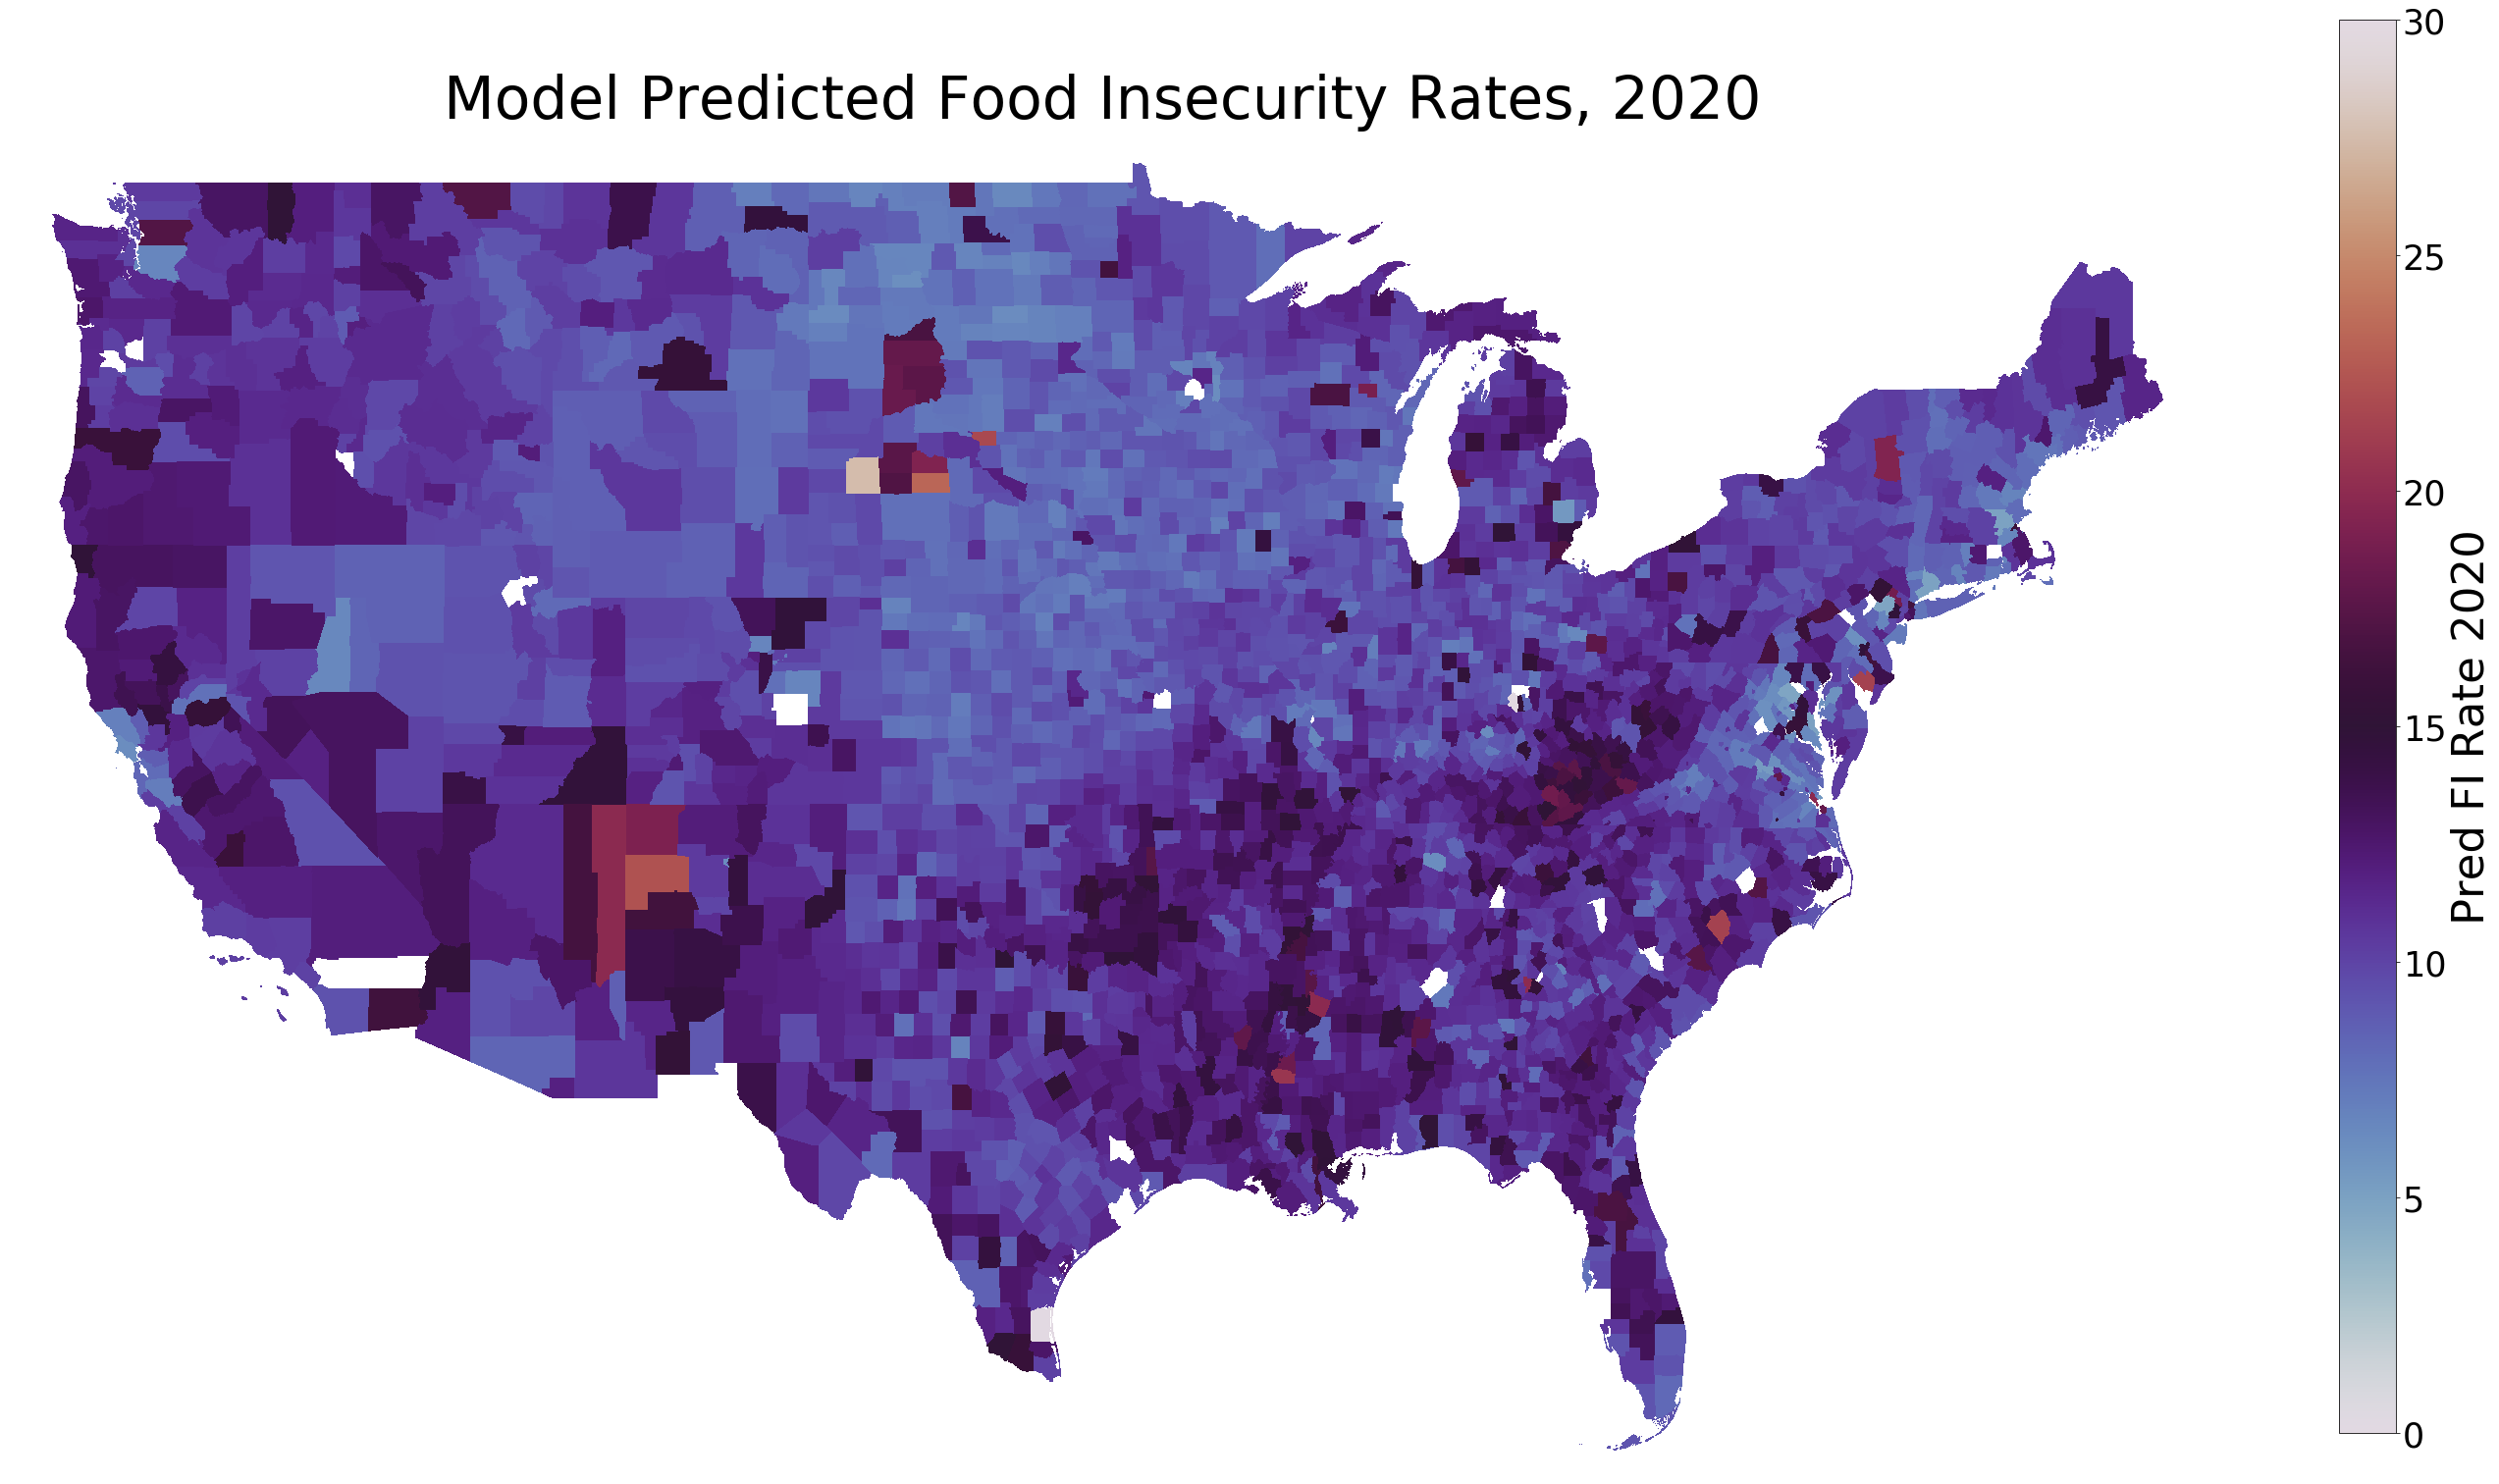

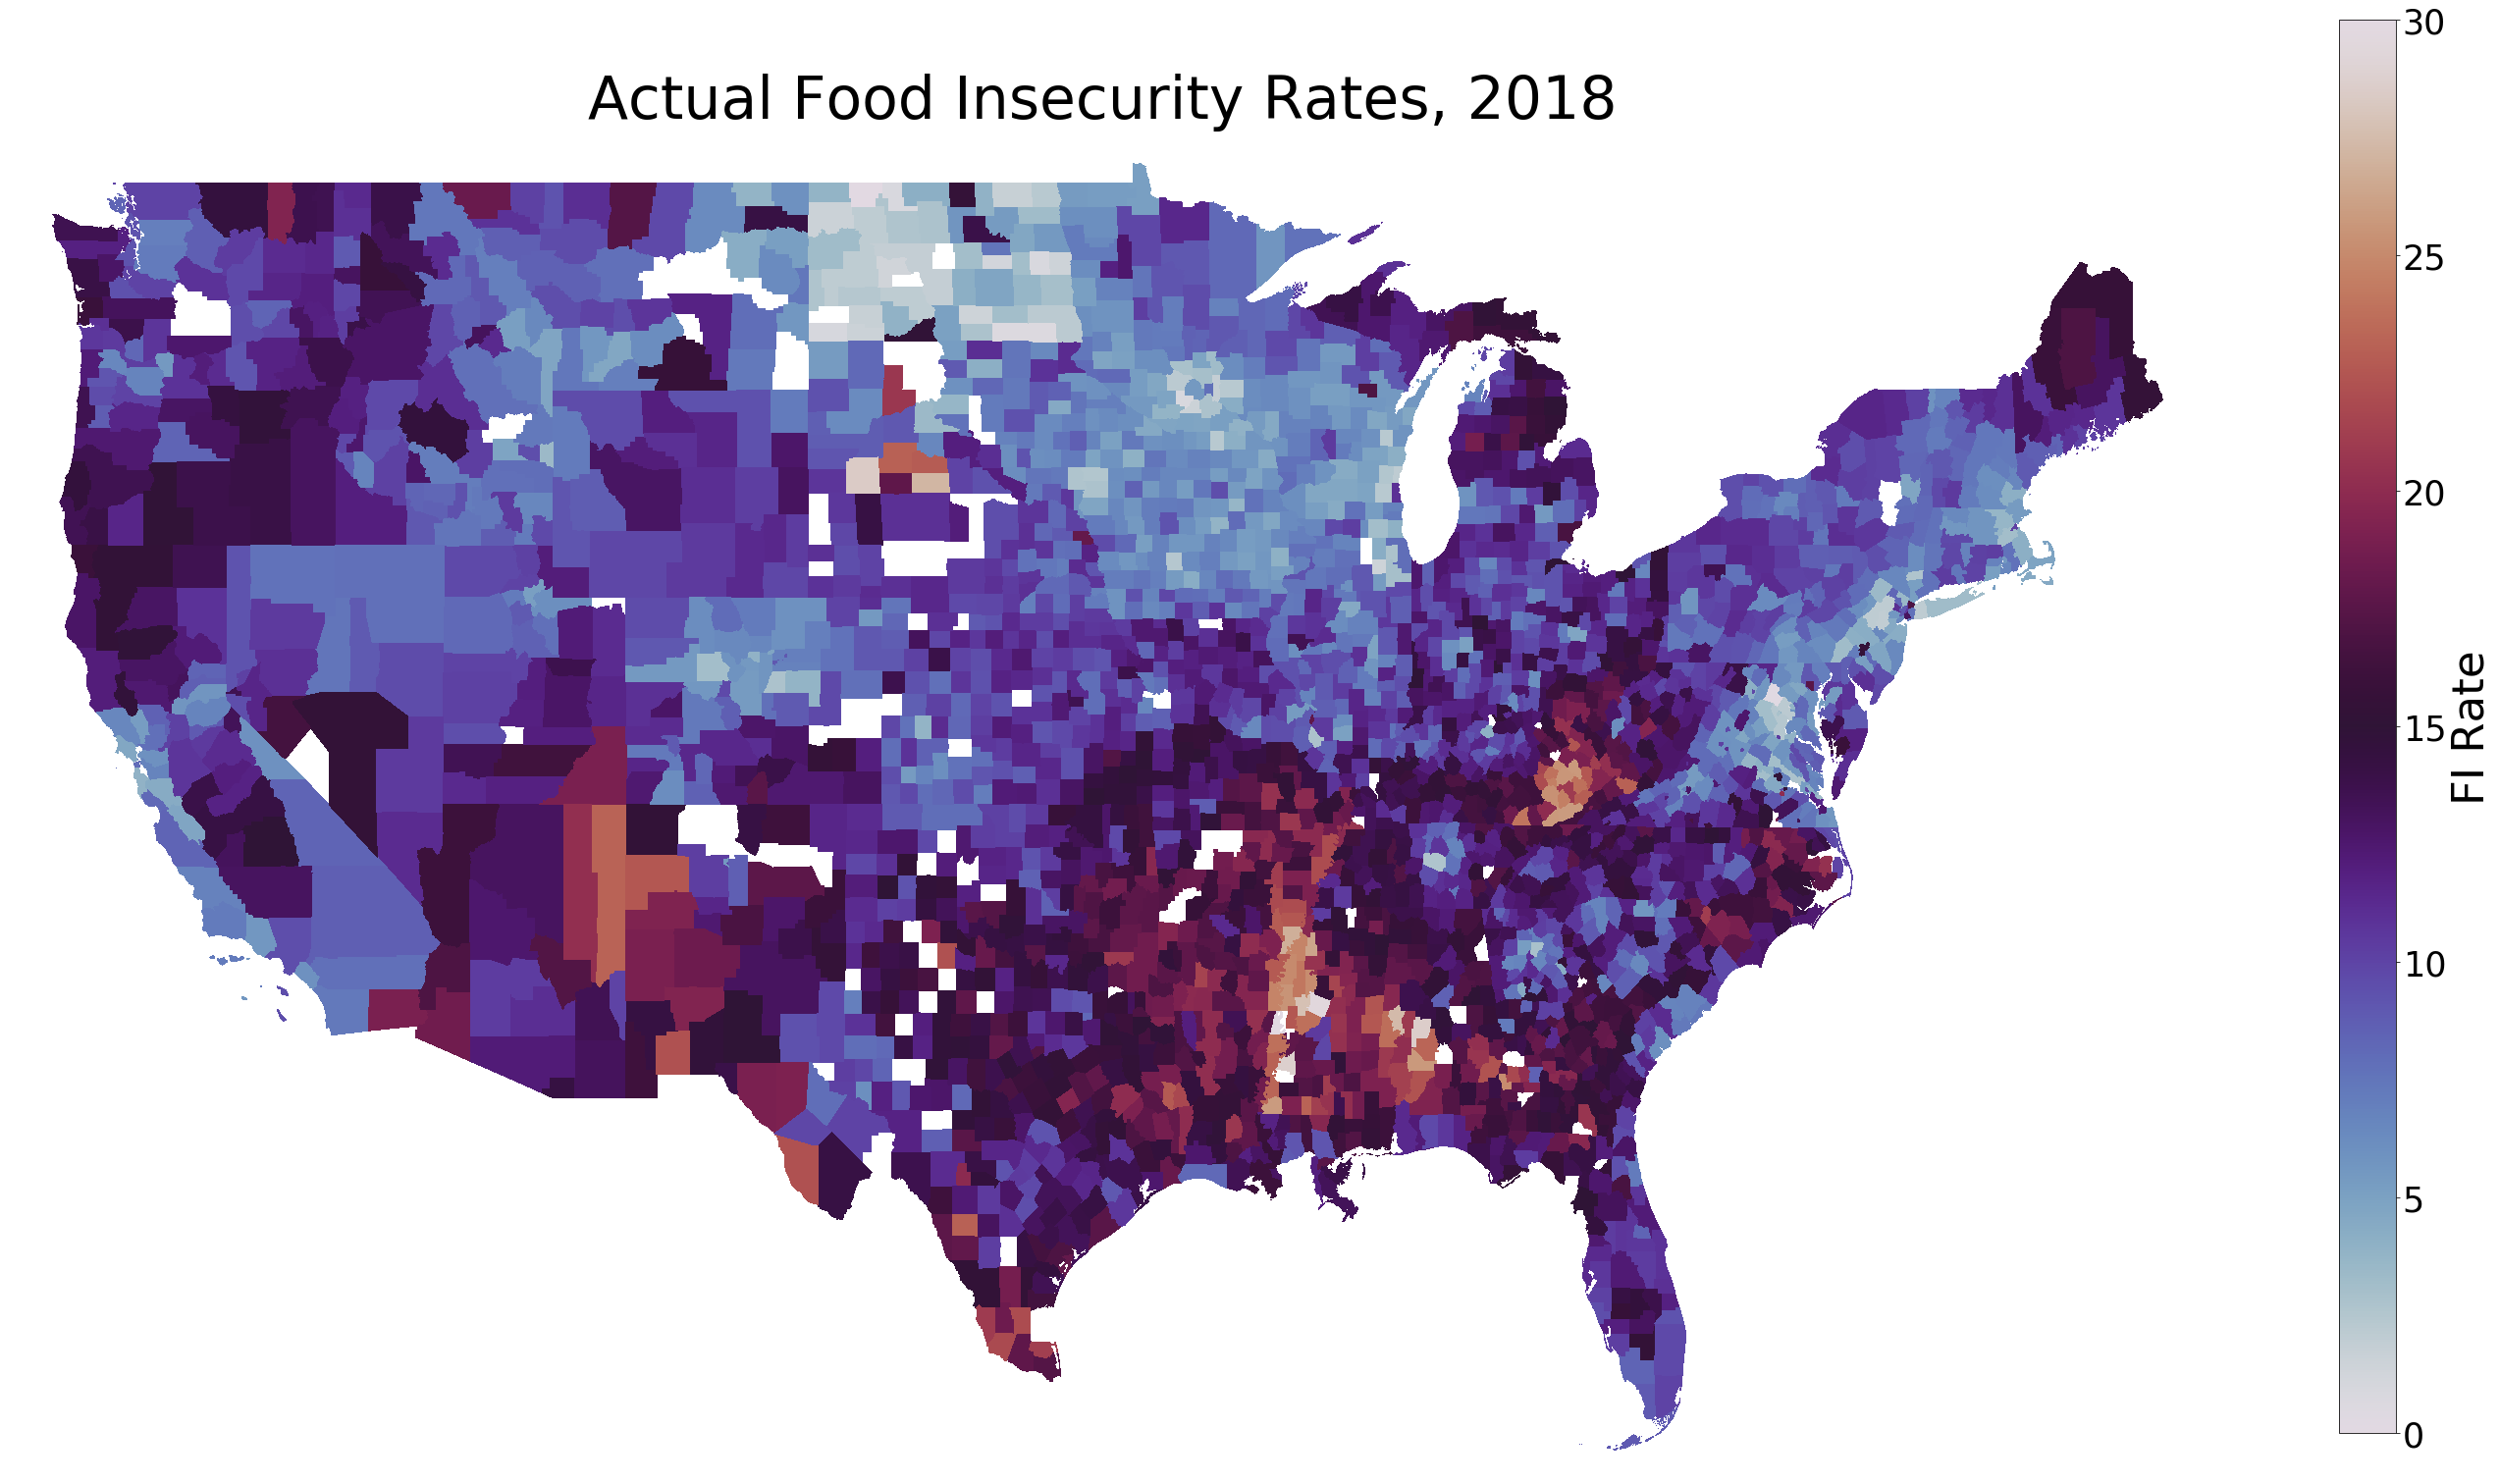

In [78]:
choropleth(df_preds,'Pred FI Rate 2020','2020','twilight','Model Predicted Food Insecurity Rates')
choropleth(df_18,'FI Rate','2018','twilight', 'Actual Food Insecurity Rates')

# Conclusion
The final RFE Model 5 was able to explain about 75% of the variance in the data, based on a cross validation R2 score of 0.7486, and was off on predictions by an average of 2%, based on Test RMSE score of 0.0198. The most important features used in this model were shown to be `Unsheltered_rate_X_Percent_asian`, `Sheltered_rate_X_Percent_white`, `Sheltered_rate_X_Percent_Black`, `Houseless_rate_X_Percent_asian`, and `Unsheltered_rate_X_Percent_male`, based on model coefficients. 
<br>**This indicates that both houselessness and race play a critical role in determining the likelihood of food insecurity, but especially so when these features interact** (ie. someone who is both Black and houseless.)<br>  

The choropleth maps on 2018 FI Rate predictions indicate that the model was able to capture the general trend of food insecurity, particularly in places that are most impacted.

### Next Steps
There is a lot of room to improve the model's ability to explain even more variance in the data, potentially by adding more features such as household income, food assistance programs, age, disability, eviction data, and transportation access.<br><br>
**The next iteration of this project aims to accomplish the following:**
- include more features
- utilize statistical testing during EDA
- employ different types of regression models
- create an interactive map to visualize features and trends
- project FI rates on unlabeled data from 2020